# Bootstrap Your Own Latent (BYOL)

This notebook is to record my understanding of the paper [Bootstrap Your Own Latent: A New Approach to Self-Supervised Learning](https://arxiv.org/abs/2006.07733) and implement the BYOL algorithm in PyTorch.

The aim is to train an encoder network (e.g., 3D ResNet-50) under the BYOL framework, and to form a good representation of the 3D medical images. 

Therefore, the original BYOL algorithm needs to be extended from 2D images to 3D images. The main difference is that the 3D images have an additional dimension, so the augmentation methods need to be modified accordingly.

## BYOL Algorithm

## Global Area

This section is to import the necessary libraries and define the global variables.

In [1]:
import copy
import torch
import numpy as np
import torchio as tio
import torch.nn as nn
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch.nn.functional as F
from functools import wraps, partial

e:\master-thesis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

This section is to load preprocessed 3D medical images from LIDC-IDRI dataset. 

By the meeting - week 13, the preprocessing steps are needed until the downsample step. The ideal case is only do the resampling once.

The brief introduction of the preprocessing steps is as follows:

1. Resample the 3D CT scans to have a uniform spacing of 1x1x1 mm.
2. Clip the HU values to the range of [-600, 1600] HU.
3. Center crop the 3D CT scans to have a size of 320x320x320.
4. Downsample the 3D CT scans to have a size of 128x128x128. (Under consideration)
5. Normalize to the range of [-1, 1]. (Under consideration)

The detailed code, please check preprocess.ipynb.

### Specific Preprocess for BYOL

The current idea is to perform the preprocessing steps after the center crop. The reason is that the center crop is to scale down the 3D CT scans to have a size of 320x320x320, which is a reasonable size for x, y, and z dimensions.

The specific preprocess for BYOL is as follows:
- for any 3D CT scan which contains the padded regions, the padded regions will be removed.
- then, perform randomresizedcrop for the 3D CT scans to have a size of 128x128x128.
- finally, normalize the 3D CT scans to the range of [-1, 1].

#### Drop Padded Slices (Have Been Updated Below)

In [2]:
def drop_invalid_range(sitk_image):
    # drop invalid slices, where slice only contains 1 single value
    vox = sitk.GetArrayFromImage(sitk_image)
    # invalid slices where slice only contains 1 single value
    invalid_start_id = 0
    invalid_end_id = vox.shape[0] - 1
    for i in range(vox.shape[0]):
        if len(np.unique(vox[i])) != 1:
            invalid_start_id = i
            break
        
    for i in range(vox.shape[0] - 1, -1, -1):
        if len(np.unique(vox[i])) != 1:
            invalid_end_id = i
            break
    
    # crop invalid slices by using crop filter
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([0, 0, invalid_start_id])
    crop_filter.SetUpperBoundaryCropSize([0, 0, vox.shape[0] - 1 - invalid_end_id])
    sitk_image = crop_filter.Execute(sitk_image)
    return sitk_image

##### Visualization

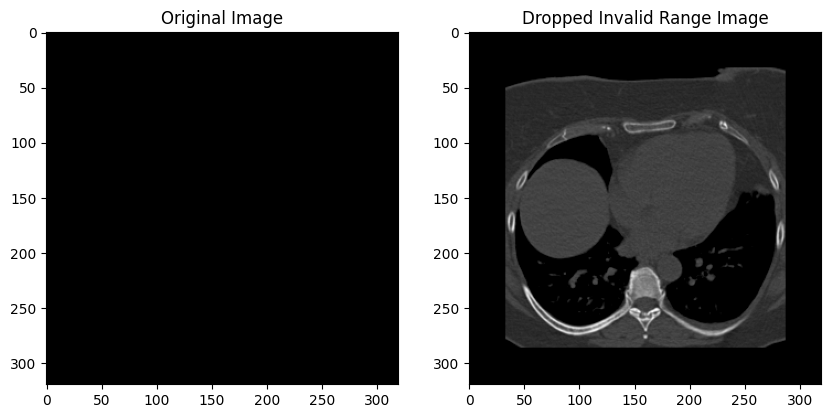

In [3]:
# E:/master-thesis/preprocess/test-results/center_cropped_image_xyz.nii.gz
demo_image = sitk.ReadImage('E:/master-thesis/preprocess/test-results/center_cropped_image_xyz.nii.gz')

# Drop invalid range which slice only contains a single value
dropped_demo_image = drop_invalid_range(demo_image)

# visualize side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(demo_image)[0], cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(dropped_demo_image)[0], cmap='gray')
plt.title('Dropped Invalid Range Image')
plt.show()

## Augmentation (Old)

In BYOL (https://arxiv.org/pdf/2006.07733.pdf), here is the augmentation described in the paper:

BYOL uses the same set of image augmentations as in SimCLR (https://arxiv.org/pdf/2002.05709.pdf). First, a random patch of the image is selected and resized to 224x224 with a random horizontal flip, followed by a color distortion, consisting of a random sequence of brightness, contrast, saturation, and hue adjustments, and an optinal grayscale conversion. Finally Gaussian blur and solarization are applied to the patches.

During self-supervised traning, BYOL uses the following image augmentations.

- **random cropping**: a **random patch** of the image is selected, with an area uniformly sampled between 8% and 100% of that of the original image, and an aspect ratio logarithmically sampled between 3/4 and 4/3. This patch is then **resized to the target size of 224 x 224 using bicubic interpolation**; ==> ***RandomResizedCrop***
- optional lef-right flip; ==> ***HorizontalFlip***
- color jittering: the brightness, contrast, saturation and hue of the image are shifted by a uniformly random offset applied on all the pixels of the same image. The order in which these shifts are performed is randomly selected for each patch; ==> ***ColorJitter***
- color dropping: an optional conversion to grayscale. When applied, output intensity for a pixel $(r, g, b)$ corresponds to its luma component, computed as $0.2989r + 0.5870g + 0.1140b$; ==> ***Grayscale***
- Gaussian blur: for a 224 x 224 image, a square Gaussian kernel of size 3 x 3 is used, with a standard deviation uniformly sampled over $[0.1, 2.0]$; ==> ***GaussianBlur***
- solarization: an optinal color transformation $x \mapsto x\cdot 1_{\{x<0.5\}} + (1-x)\cdot 1_{\{x\geq 0.5\}}$ for pixels with values in $[0, 1]$. ==> ***Solarization***

### Default SimCLR augmentation

The image augmentations parametres are listed in Table 6 in paper BYOL, see details in paper.

#### ColorJitter to Huge Gamma Correction

First of all, what is color jitter?

Color jitter randomly change the brightness, contrast, saturation and hue of an image, by the documentation of *PyTorch* (https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html). 

From the paper of "*Augmenting Medical Imaging: A Comprehensive Catalogue of 65 Techniques for Enhanced Data Analysis*" (https://arxiv.org/pdf/2303.01178.pdf#:~:text=Color%20jitter%20is%20a%20data,%2C%20brightness%2C%20and%20contrast%20values), it said, color jitter is a data augmentation technique that involves randomly perturbing the color of an image by making small changes to its hue, saturation, brightness, and contrast values. By introducing random variations in the color of an image, color jitter can help a model become more robust to variations in color that may be present in different images of the same object or tissue.  For example, color variations may be caused by differences in lighting conditions or staining procedures used to prepare tissue samples. By applying color jitter to an image, the model can learn to better recognize and classify the object or tissue despite these variations in color, from the paper "*Differential data augmentation techniques for medical imaging classification tasks*".

<u>*However, in my case, I got 3D medical images that are all grayscale, what should I do then?*</u>

Here is an answer by author of TorchIO (https://github.com/fepegar/torchio/issues/205):
- *Q: Would it be possible that in TorchIO we have Colorjitter like transformation that we have in PyTorch?*
- *A: I think grayscale equivalent would be torchio.RandomNoise*

However, I am not sure this is correct and there seems no strong evidence to support this.

Instead, in PyTorch, the *ColorJitter* is still useful for grayscale images, below is the visiualization of the *ColorJitter* for grayscale images.

However, I have tried to apply the defined color jitter to the image after center cropping with the resulting shape (320, 320, 320), it seems the result is very very poor. But, when applied to the image after simply resampling without LU conversion, the result is satisfactory. Therefore, I was wondering whether the color jitter should be applied to the grayscale image, since the raw image is grayscale and the color jitter is designed for RGB images.

<font color=red>***Question**: Does the color jitter work for grayscale images? Or should I take the opinion of the author of TorchIO which is to use RandomNoise instead? Will this option aims to strengthen the model can be robust in noise.*</font>

There is another post (https://github.com/fepegar/torchio/issues/232) said, for MRI gamma augmentation would be interesting too (it changes the contrast) as it is used here https://arxiv.org/pdf/2003.01995.pdf (Cf eq 4).

Therefore, maybe brightness and contrast are more suitable for grayscale images.

Medical Image Contrast Enhancement based on Gamma Correction: https://www.researchgate.net/profile/Somasundaram-Karuppanagounder/publication/265352419_Medical_Image_Contrast_Enhancement_based_on_Gamma_Correction/links/5409acc40cf2822fb73b330a/Medical-Image-Contrast-Enhancement-based-on-Gamma-Correction.pdf, it states that the perofrmance of the method is evaluated with MRI and CT scan images and is found to give satifactory results.

##### Visuialization

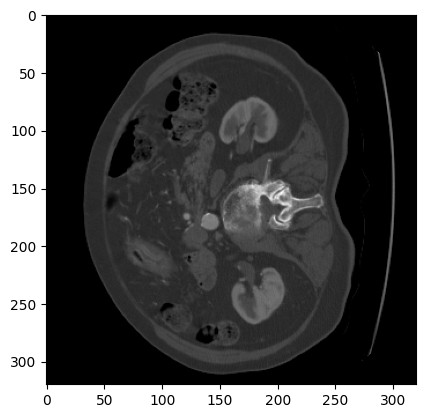

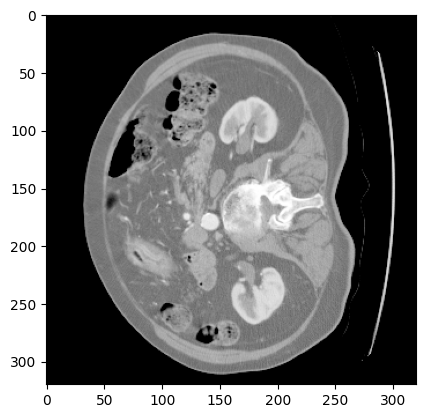

In [4]:
class Gamma(tio.Lambda):
    def __init__(self, gamma):
        super().__init__(self.apply_gamma)
        self.gamma = gamma

    def apply_gamma(self, tensor):
        return tensor ** self.gamma

tio_image = tio.ScalarImage('E:/master-thesis/preprocess/test-results/center_cropped_image_z_most_common.nii.gz')
img = tio_image.data
plt.imshow(img[0, :, :, 0], cmap='gray')
plt.show()

# apply gamma correction to the image
gamma = 3

transform = tio.Compose([
    Gamma(gamma),
])

transformed = transform(tio_image)
img = transformed.data
plt.imshow(img[0, :, :, 0], cmap='gray')
plt.show()

#### RandomGrayScale (Unnecessary)

The same goes as above, the raw image is grayscale, so the grayscale conversion should not be necessary, I assume.

#### RandomHorizontalFlip (Left-Right Flip)

In this section, the random horizontal flip is applied by using "TorchIO" library, with the probability of 0.5 according to the paper.

I am trying to perform the horizontal flip with left-right option to the whole volume, which is for each slice in the volume, the left-right flip is applied.

In TorchIO, the axis 0 is the left-right direction, and that is what I want.

##### Visualization

torch.Size([1, 128, 128, 128])


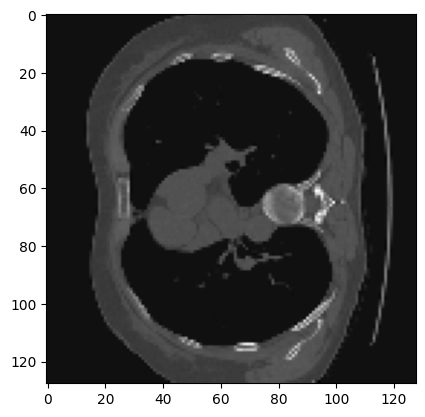

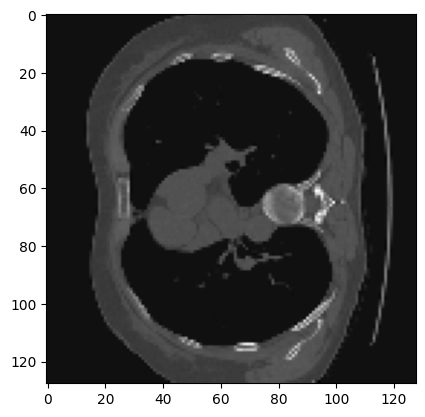

In [5]:
# E:\master-thesis\preprocess\test-results\center_cropped_image_z_most_common.nii.gz
tio_image = tio.ScalarImage('E:/master-thesis/preprocess/test-results/normalized_image.nii.gz')
img = tio_image.data
print(img.shape) # channel, x, y, z

plt.imshow(img[0, :, :, 63], cmap='gray')
plt.show()

flip = tio.RandomFlip(axes=(0,), p=0.5)
flipped = flip(img)
plt.imshow(flipped[0, :, :, 63], cmap='gray')
plt.show()

#### GaussianBlur

TorchIO has performed the GaussianBlur to the entire volume.

##### Visualization

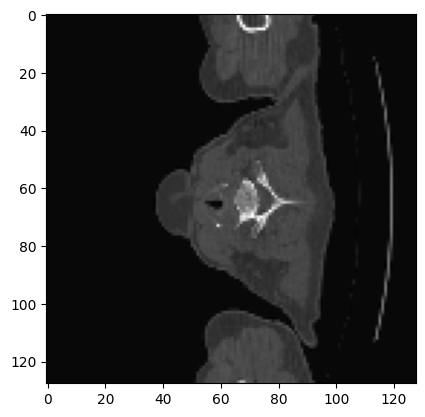

In [6]:
# in 2D pytorch, kernel size is 3 by 3, sigma is (0.1, 2.0)
blur = tio.RandomBlur(std=(0.1, 2.0), p=0.2)
blurred = blur(flipped)
plt.imshow(blurred[0, :, :, -1], cmap='gray')
plt.show()

## Agumentation In Use

### RandomResizedCrop (V2 Deprecated)

In [7]:
class RandomResizedCrop(tio.Transform):
    def __init__(self, size, scale=(0.25, 1.0), aspect_ratio=(0.75, 1.33)):
        super().__init__()
        self.size = self.parse_size(size)
        self.scale = scale
        self.aspect_ratio = aspect_ratio
        
    def apply_transform(self, subject):
        image = subject['image'] # shape: (c, z, x, y)
        # randomly crop the original image to a patch by the area of (25% ~ 100%) -> (x, y, 320)
        cropped = self.random_crop(image, self.scale)
        # resample the cropped image to the size of (128, 128, 128)
        cropped_w, cropped_h, cropped_d = cropped.shape[1], cropped.shape[2], cropped.shape[3]
        new_spacing = [cropped_w/self.size[0], cropped_h/self.size[1], cropped_d/self.size[2]]
        resampled = tio.Resample(new_spacing, image_interpolation='bspline')(cropped)
        subject['image'] = resampled
        return subject
        
    def random_crop(self, image, scale):
        scale_factor = np.random.uniform(*scale)
        # crop for x, y axis for all slices and crop for z axis for 320 slices
        cropped = tio.CropOrPad(int(scale_factor*image.shape[1]), int(scale_factor*image.shape[2]))(image)
        return cropped

    def parse_size(self, size):
        if isinstance(size, int):
            return (size, size, size)
        elif isinstance(size, tuple):
            return size
        else:
            raise ValueError(f'Invalid size: {size}')

### RandomResizedCrop V3 In Use

In [8]:
def drop_invalid_range(sitk_image):
    # drop invalid slices, where slice only contains 1 single value
    vox = sitk.GetArrayFromImage(sitk_image)
    
    # flag: 0 -> no need to crop, 1 -> crop
    flag_z = 1 if len(np.unique(vox[0])) == 1 else 0
    flag_y = 1 if len(np.unique(vox[:, 0])) == 1 else 0
    flag_x = 1 if len(np.unique(vox[:, :, 0])) == 1 else 0
    
    if flag_z == 0 and flag_y == 0 and flag_x == 0:
        # print('No need to crop')
        return sitk_image
    
    # invalid slices where slice only contains 1 single value
    # print('Cropping')
    start_id_depth = 0
    start_id_width = 0
    start_id_height = 0
    
    end_id_depth = vox.shape[0] - 1
    end_id_width = vox.shape[2] - 1
    end_id_height = vox.shape[1] - 1
    
    for i in range(vox.shape[0]):
        if len(np.unique(vox[i])) != 1:
            start_id_depth = i
            break
        
    for i in range(vox.shape[0] - 1, -1, -1):
        if len(np.unique(vox[i])) != 1:
            end_id_depth = i
            break
        
    for i in range(vox.shape[1]):
        if len(np.unique(vox[:, i])) != 1:
            start_id_height = i
            break
    
    for i in range(vox.shape[1] - 1, -1, -1):
        if len(np.unique(vox[:, i])) != 1:
            end_id_height = i
            break
        
    for i in range(vox.shape[2]):
        if len(np.unique(vox[:, :, i])) != 1:
            start_id_width = i
            break
        
    for i in range(vox.shape[2] - 1, -1, -1):
        if len(np.unique(vox[:, :, i])) != 1:
            end_id_width = i
            break
    
    # # crop invalid slices by using crop filter
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([start_id_width, 
                                          start_id_height, 
                                          start_id_depth])
    crop_filter.SetUpperBoundaryCropSize([vox.shape[2] - 1 - end_id_width, 
                                          vox.shape[1] - 1 - end_id_height, 
                                          vox.shape[0] - 1 - end_id_depth])
    sitk_image = crop_filter.Execute(sitk_image)
    return sitk_image

def generate_random_box(sitk_image, scale=(0.25, 1.0)):
    width, height, depth = sitk_image.GetSize()
    # random size with random x, y, z
    scale_width, scale_height, scale_depth = np.random.uniform(*scale), np.random.uniform(*scale), np.random.uniform(*scale)
    width_box, height_box, depth_box = int(scale_width*width), int(scale_height*height), int(scale_depth*depth)
    # randomly generate the start position of the box
    start_width, start_height, start_depth = np.random.randint(0, width - width_box), np.random.randint(0, height - height_box), np.random.randint(0, depth - depth_box)
    # use the box to crop the original image
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([start_width, start_height, start_depth])
    crop_filter.SetUpperBoundaryCropSize([width - width_box - start_width, 
                                          height - height_box - start_height, 
                                          depth - depth_box - start_depth])
    cropped = crop_filter.Execute(sitk_image)
    return cropped

# apply resample filter to the cropped image to the fixed shape of (128, 128, 128)
def resample2target(sitk_image, new_size=(128, 128, 128), interpolation=sitk.sitkBSpline):
    # original spacing
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    ratio = [sz/nsz for sz, nsz in zip(original_size, new_size)]
    # new spacing
    new_spacing = [osz*rsz for osz, rsz in zip(original_spacing, ratio)]
    # resample filter
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    # interpolation method
    resample_filter.SetInterpolator(interpolation)
    resample_filter.SetOutputOrigin(sitk_image.GetOrigin())
    resample_filter.SetOutputDirection(sitk_image.GetDirection())
    resampled = resample_filter.Execute(sitk_image)
    return resampled

class RandomResizedCrop(tio.Transform):
    def __init__(self, size, scale=(0.25, 1.0), aspect_ratio=(0.75, 1.33)):
        super().__init__()
        self.size = self.parse_size(size)
        self.scale = scale
        self.aspect_ratio = aspect_ratio
    
    def apply_transform(self, subject):
        # drop invalid slices
        image = subject['image']
        sitk_image = image.as_sitk()
        dropped = drop_invalid_range(sitk_image)
        cropped = generate_random_box(dropped, scale=self.scale)
        # resample the cropped image to the size of (128, 128, 128)
        resampled = resample2target(cropped, new_size=self.size)
        # convert the resampled image back to torchio image, from sitk
        resampled = tio.ScalarImage.from_sitk(resampled)
        subject['image'] = resampled
        return subject
    
    def parse_size(self, size):
        if isinstance(size, int):
            return (size, size, size)
        elif isinstance(size, tuple):
            return size
        else:
            raise ValueError(f'Invalid size: {size}')

## BYOL Method

### Helper functions

In [9]:
def default(val, def_val):
    return def_val if val is None else val

def flatten(t):
    return t.reshape(t.shape[0], -1)

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance
            
            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):
    return next(module.parameters()).device

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

### Loss function

In [10]:
def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

### Exponential moving average

In [11]:
class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new
    
def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

### Multi Layer Perceptron (MLP)

In [12]:
def MLP(dim, projection_size, hidden_size=4096):
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size)
    )

### Wrapper for Base NNs

In [13]:
class NetWrapper(nn.Module):
    def __init__(self, net, projection_size, projection_hidden_size, layer=-2):
        super().__init__()
        self.net = net
        self.layer = layer
        
        self.projector = None
        self.projection_size = projection_size
        self.projection_hidden_size = projection_hidden_size
        
        self.hidden = {}
        self.hook_registered = False
        
    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None
    
    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = flatten(output)
        
    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True
        
    @singleton('projector')
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        create_mlp_fn = MLP
        projector = create_mlp_fn(dim, self.projection_size, self.projection_hidden_size)
        return projector.to(hidden)
    
    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)
        
        if not self.hook_registered:
            self._register_hook()
            
        self.hidden.clear()
        _ = self.net(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()
        
        assert hidden is not None, f'hidden layer ({self.layer}) never emitted an output'
        return hidden
    
    def forward(self, x, return_projection=True):
        representation = self.get_representation(x)
        
        if not return_projection:
            return representation
        
        projector = self._get_projector(representation)
        projection = projector(representation)
        return projection, representation

### BYOL framework

In [14]:
class BYOL(nn.Module):
    def __init__(
        self,
        net,
        image_size,
        image_depth, 
        hidden_layer=-2,
        projection_size=256,
        projection_hidden_size=4096,
        augment_fn=None,
        augment_fn2=None,
        moving_average_decay=0.99
    ):
        super().__init__()
        self.net = net
        
        # area for augmentation functions - compose
        DEFAULT_AUG = tio.Compose([
            # randomresizedcrop
            RandomResizedCrop(size=(image_size, image_size, image_depth)),
            # randomflip
            tio.RandomFlip(axes=(0,), p=0.5),
            # random gamma
            tio.RandomGamma((-2, 2), p=0.4),
            # random blur: view 1 p=0.2, view 2 p=1
            tio.RandomBlur(std=(0.1, 2.0), p=0.2),
            # normalize
            tio.RescaleIntensity((0, 1)),
        ])
        
        self.augment1 = default(augment_fn, DEFAULT_AUG)
        self.augment2 = default(augment_fn2, self.augment1)
        
        self.online_encoder = NetWrapper(
            net, 
            projection_size,
            projection_hidden_size,
            layer=hidden_layer
        )
        
        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)
        
        self.online_predictor = MLP(projection_size, projection_size, projection_hidden_size)
        
        # get device of network and make wrapper same device
        device = get_module_device(net)
        self.to(device)
        
        # send a mock 3D image tensor to instantiate singleton parameters
        self.forward(torch.randn(2, 1, image_size, image_size, image_depth, device=device))
        
    @singleton('target_encoder')
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        set_requires_grad(target_encoder, False)
        return target_encoder
    
    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None
        
    def update_moving_average(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(
            self.target_ema_updater,
            self.target_encoder,
            self.online_encoder
        )
        
    def forward(self, x, return_embedding=False, return_projection=True):
        if return_embedding:
            return self.online_encoder(x, return_projection = return_projection)
        
        x_cpu = x.cpu()
        subjects = [tio.Subject(image=tio.ScalarImage(tensor=x_cpu[i])) for i in range(x_cpu.shape[0])]
        
        first_augmented_two_views = tio.SubjectsDataset(subjects, transform=self.augment1)
        second_augmented_two_views = tio.SubjectsDataset(subjects, transform=self.augment2)
        
        # load two views in the tensor as image one
        image_one = torch.stack([subject['image'].data for subject in first_augmented_two_views]).to(x.device)
        image_two = torch.stack([subject['image'].data for subject in second_augmented_two_views]).to(x.device)
        
        del x_cpu
        
        images = torch.cat([image_one, image_two], dim=0)
        
        online_projections, _ = self.online_encoder(images)
        online_predictions = self.online_predictor(online_projections)
        
        online_pred_one, online_pred_two = online_predictions.chunk(2, dim=0) # split into two tensors
        
        with torch.no_grad():
            target_encoder = self._get_target_encoder()
            
            target_projections, _ = target_encoder(images)
            target_projections = target_projections.detach() # detach from computational graph to prevent backpropagation
            
            target_proj_one, target_proj_two = target_projections.chunk(2, dim=0)
            
        loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        loss_two = loss_fn(online_pred_two, target_proj_one.detach())
        
        loss = loss_one + loss_two
        return loss.mean()

## 3D ResNet-50

### Utility functions

In [15]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

### Basic Block

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

### Bottleneck Block

In [17]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

### ResNet Class

In [18]:
class ResNet(nn.Module):
    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=400):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Generate model

In [19]:
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

## DataLoader

In [20]:
# tio.Subject: create subjects which stored in the folder: E:\master-thesis\methods\demo_center_cropped
folder_path = 'E:/master-thesis/methods/demo_center_cropped'
pids = ['LIDC-IDRI-{:04d}'.format(i+1) for i in range(10)]
suffix = '_center_cropped.nii.gz'
subjects = []
for pid in pids:
    image_path = folder_path + '/' + pid + suffix
    subject = tio.Subject(
        image=tio.ScalarImage(image_path)
    )
    subjects.append(subject)

In [21]:
# create dataset
dataset = tio.SubjectsDataset(subjects)
# training loader
training_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
)
for i, batch in enumerate(training_loader):
    # check the shape of the batch
    print(batch['image']['data'].shape)
    # images
    images = batch['image']['data']

torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])


## Training with Early Stopping

This section is to train the 3D ResNet under the BYOL framework with early stopping strategy.

In [22]:
# 3D image with shape (1, 128, 128, 128) -> (c, x, y, z), there are 1010 patients with 1018 images 
resnet50 = generate_model(50, n_input_channels=1, n_classes=1010)

In [ ]:
byol = BYOL(
    resnet50,
    image_size=64,
    image_depth=64,
    hidden_layer='avgpool',
    projection_size=256,
    projection_hidden_size=4096,
    moving_average_decay=0.99
)

In [ ]:
# optimizer
optimizer = torch.optim.Adam(byol.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(training_loader), eta_min=0)

epochs = 10
losses_list = []
for epoch in range(epochs):
    losses = []
    for i, batch in enumerate(training_loader):
        loss = byol(batch['image']['data'])
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        byol.update_moving_average()
    
    print(f'Epoch {epoch+1}, Loss: {np.mean(losses)}')
    losses_list.append(np.mean(losses))

In [ ]:
plt.plot(losses_list)